# MAGMA experimnetations

## Artificial data : Common HP + Common grid

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import warnings

plt.style.use("bmh")
sys.path.append("../src/")
warnings.filterwarnings("ignore")

from kernels import ExponentiatedQuadraticKernel, GaussianKernel
from MAGMAfixed import MAGMA

### Exponentiated Quadratic Kernel

In [2]:
N = 100
M = 20

t0 = 0
tN = 10 + 1e-3

common_T = np.linspace(t0, tN, N)
print(common_T.shape)

(100,)


In [3]:
a = np.random.uniform(-2, 2)
b = np.random.uniform(0, 10)

m0 = a * common_T + b
m0_function = lambda t : a * t + b
print(m0.shape)

(100,)


In [4]:
theta0 = np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))])
print(theta0)

[135.43311638   5.65798019]


In [5]:
K_theta0 = ExponentiatedQuadraticKernel.compute_all(theta0, common_T)
print(K_theta0.shape)

(100, 100)


In [6]:
mu0 = np.random.multivariate_normal(m0, K_theta0)
print(mu0.shape)

(100,)


In [7]:
Theta = np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))])
Sigma = np.random.uniform(0, 1)

print(Theta)
print(Sigma)

[105.9801555    4.31941708]
0.9739786889270463


In [8]:
Y = np.zeros((M, N))
for i in range(M):
    C_Theta = ExponentiatedQuadraticKernel.compute_all(Theta, common_T)
    Psi_Theta_Sigma = C_Theta + Sigma * np.identity(N)
    Yi = np.random.multivariate_normal(mu0, Psi_Theta_Sigma)
    Y[i] = Yi
print(Y.shape)

(20, 100)


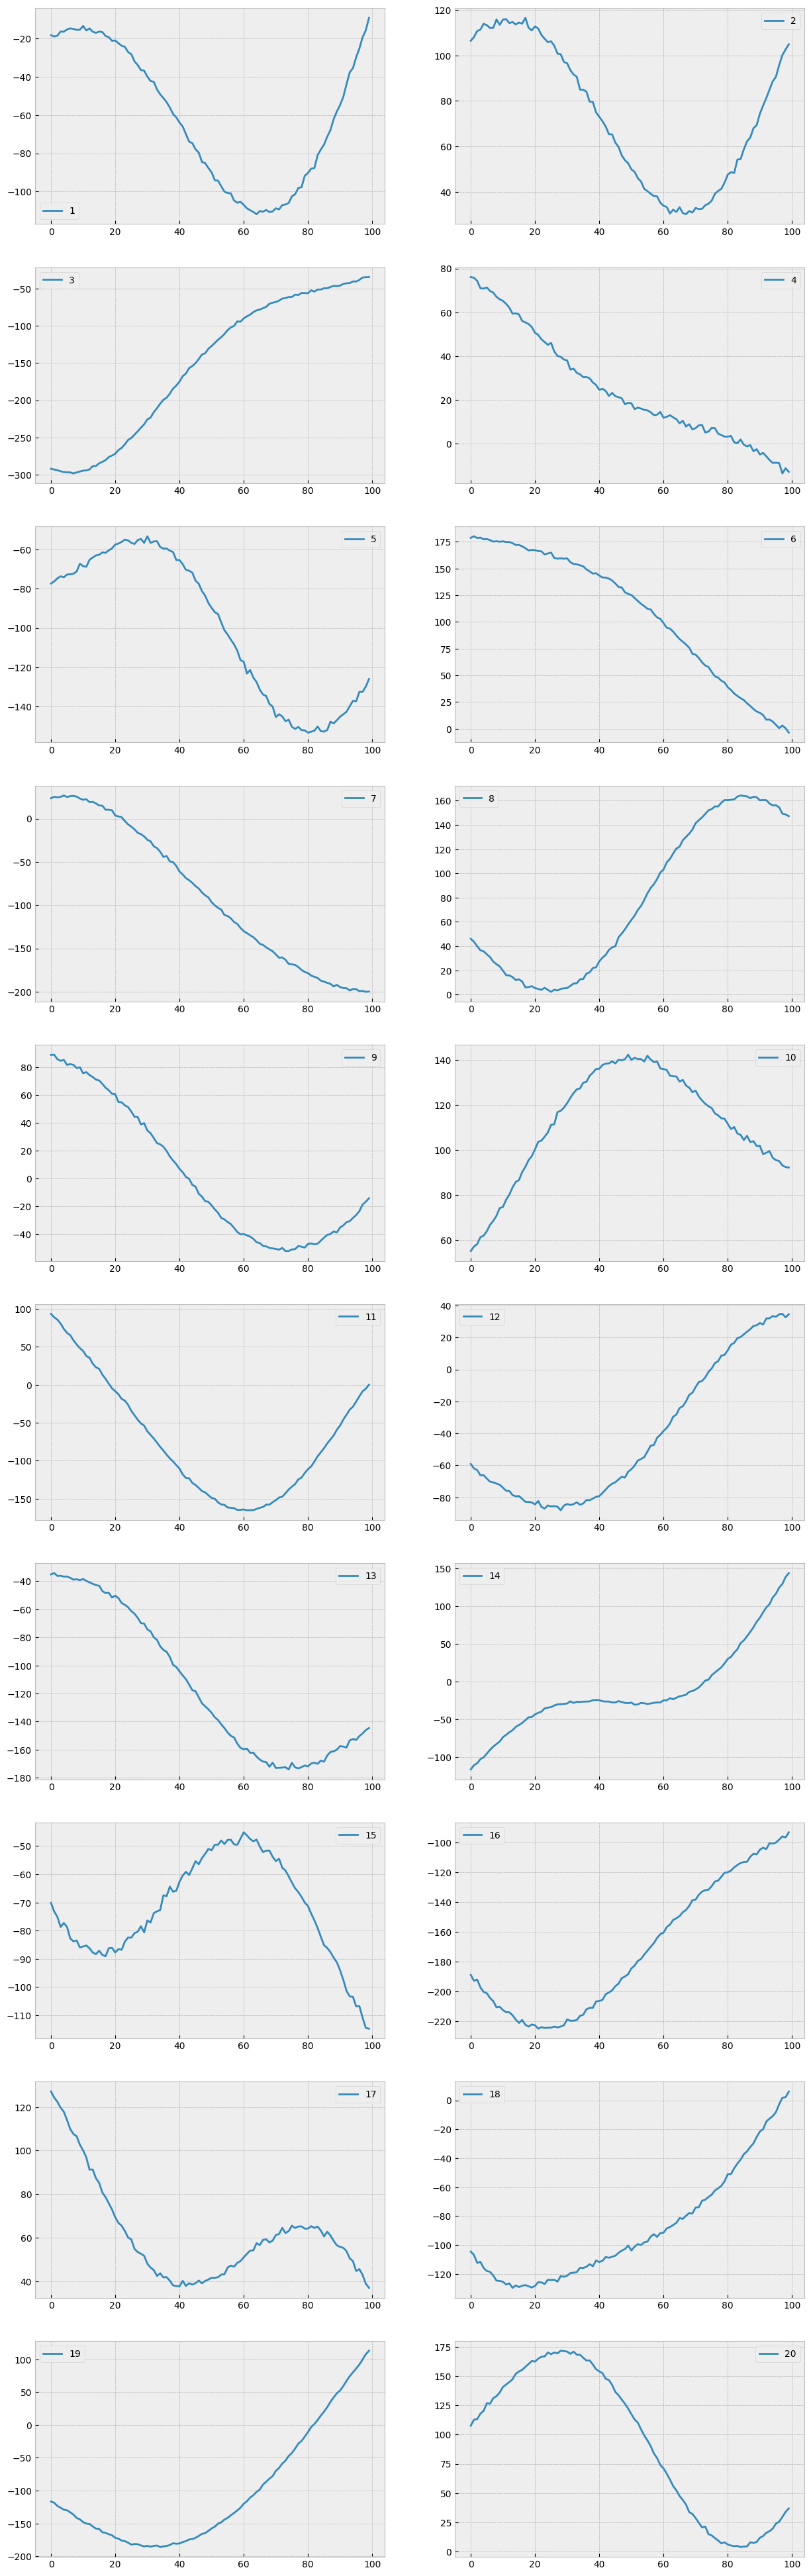

In [9]:
plt.figure(figsize=(15, int(np.ceil(M/2)) * 5))
for i in range(1, M + 1):
    plt.subplot(int(np.ceil(M/2)), 2, i)
    plt.plot(Y[i - 1], label=f"{i}")
    plt.legend()
plt.show()

In [10]:
model = MAGMA(
    T=None,
    Y=Y,
    common_T=common_T,
    m0=np.zeros(len(m0)), 
    m0_function=m0_function,
    theta0=np.array([np.random.uniform(0.98, 1.02), np.random.uniform(0.98, 1.02)]), 
    Theta=np.array([np.random.uniform(0.98,1.02), np.random.uniform(0.98,1.02)]), 
    Sigma=np.random.uniform(0.49,0.51),
    common_hp_flag=True,
    common_grid_flag=True,
    save_history_flag=True,
    scipy_optimize_display=True,
    kernel_k=ExponentiatedQuadraticKernel,
    kernel_c=ExponentiatedQuadraticKernel,
)

In [11]:
model.fit(max_iterations=1, eps=1e-2)

MAGMA Training:   0%|          | 0/1 [00:00<?, ?it/s] This problem is unconstrained.


theta0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17022D+03    |proj g|=  3.17818D+03

At iterate    1    f=  3.86251D+02    |proj g|=  4.87978D+03

At iterate    2    f= -7.26439D+01    |proj g|=  2.90741D+02

At iterate    3    f= -1.00640D+02    |proj g|=  2.52247D+02

At iterate    4    f= -2.15779D+02    |proj g|=  1.13497D+02

At iterate    5    f= -2.60953D+02    |proj g|=  6.85878D+01

At iterate    6    f= -2.93983D+02    |proj g|=  1.24987D+02

At iterate    7    f= -3.13049D+02    |proj g|=  1.72446D+02

At iterate    8    f= -3.27450D+02    |proj g|=  1.76260D+02

At iterate    9    f= -3.38850D+02    |proj g|=  1.39821D+02

At iterate   10    f= -3.46860D+02    |proj g|=  8.77882D+01

At iterate   11    f= -3.51359D+02    |proj g|=  4.28720D+01

At iterate   12    f= -3.53391D+02    |proj g|=  1.22728D+01

At iterate   13    

 This problem is unconstrained.



At iterate    2    f=  1.03732D+05    |proj g|=  9.53121D+04

At iterate    3    f=  6.15960D+04    |proj g|=  4.40423D+04

At iterate    4    f=  4.32953D+04    |proj g|=  2.57392D+04

At iterate    5    f=  2.93289D+04    |proj g|=  1.38635D+04

At iterate    6    f=  2.07709D+04    |proj g|=  7.73770D+03

At iterate    7    f=  1.49861D+04    |proj g|=  4.25745D+03

At iterate    8    f=  1.11260D+04    |proj g|=  2.34578D+03

At iterate    9    f=  8.51651D+03    |proj g|=  1.29175D+03

At iterate   10    f=  6.89723D+03    |proj g|=  6.58018D+02

At iterate   11    f=  5.49243D+03    |proj g|=  5.96746D+02

At iterate   12    f=  4.83590D+03    |proj g|=  2.69911D+02

At iterate   13    f=  4.23051D+03    |proj g|=  5.64966D+02

At iterate   14    f=  3.92546D+03    |proj g|=  7.54392D+01

At iterate   15    f=  3.71203D+03    |proj g|=  4.86463D+01

At iterate   16    f=  3.57592D+03    |proj g|=  1.98743D+01

At iterate   17    f=  3.54932D+03    |proj g|=  1.73236D+02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
MAGMA Training: 100%|██████████| 1/1 [00:19<00:00, 19.52s/it]


In [12]:
model.scipy_optimize_display = False
model.fit(max_iterations=49, eps=1e-2)

MAGMA Training:  47%|████▋     | 23/49 [02:31<02:50,  6.58s/it]


In [13]:
history = model.history
len(history)

26

In [14]:
LL_theta0 = []
LL_Theta_Sigma = []

for epoch_history in history[1:]:
    LL_theta0.append(epoch_history["LL_theta0"])
    LL_Theta_Sigma.append(epoch_history["LL_Theta_Sigma"])

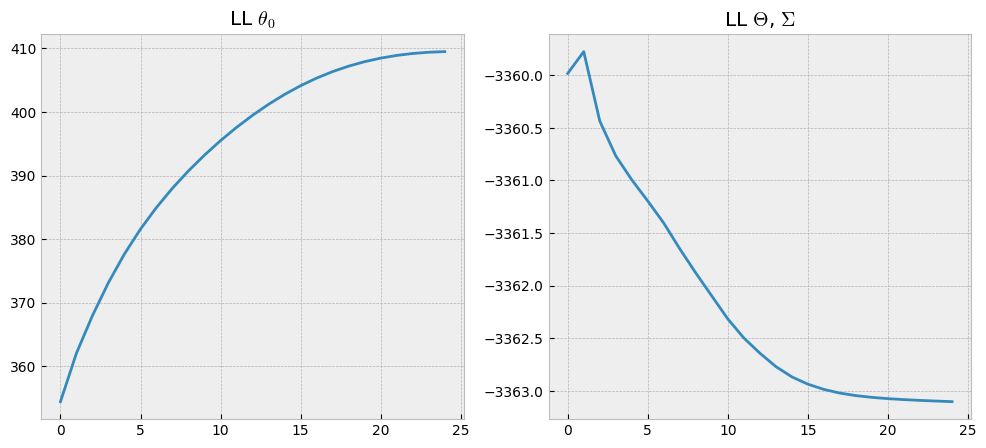

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(LL_theta0)
plt.title("LL $\\theta_0$")
plt.subplot(1, 2, 2)
plt.plot(LL_Theta_Sigma)
plt.title("LL $\Theta$, $\Sigma$")
plt.show()

In [16]:
Sigma_estim = []
for epoch_history in history:
    Sigma_estim.append(epoch_history["Sigma"]**2)

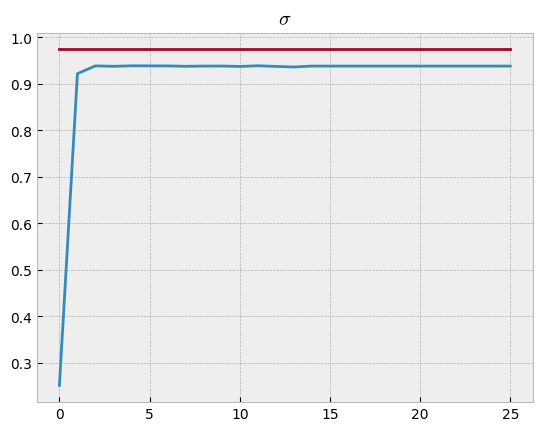

In [17]:
plt.plot(Sigma_estim,label="$\sigma$ predict")
plt.plot(Sigma*np.ones(len(Sigma_estim)),label="true $\sigma$")
plt.title("$\sigma$")
plt.show()

In [18]:
m0_estim_norms = []
for epoch_history in history[1:]:
    m0_estim_norms.append(np.linalg.norm(epoch_history["m0"]))

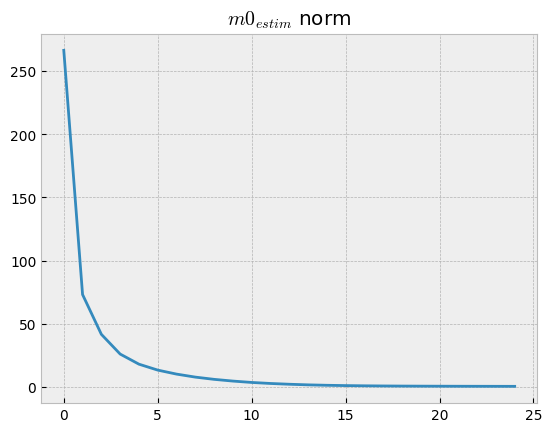

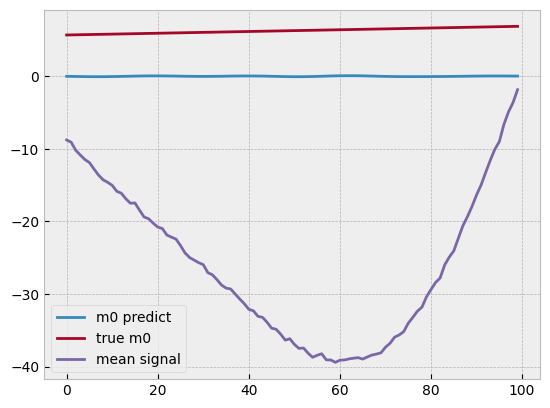

In [19]:
plt.plot(m0_estim_norms)
plt.title("$m0_{estim}$ norm")
plt.show()
plt.plot(history[-1]["m0"],label="m0 predict")
plt.plot(m0, label="true m0")
plt.plot(Y.mean(axis=0),label = "mean signal")
plt.legend()
plt.show()

In [20]:
theta0_predict = []
for epoch_history in history:
    theta0_predict.append(epoch_history["theta0"])
theta0_predict = np.array(theta0_predict)
print(model.theta0)

[0.14382645 0.74828294]


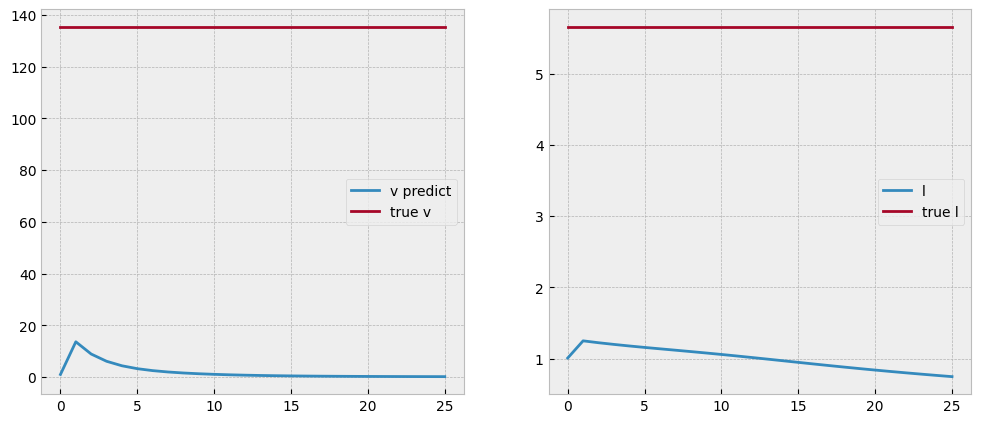

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(theta0_predict[:, 0], label="v predict")
plt.plot(theta0[0]*np.ones(len(theta0_predict[:, 0])), label="true v")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(theta0_predict[:, 1], label="l")
plt.plot(theta0[1]*np.ones(len(theta0_predict[:, 0])), label="true l")

plt.legend()
plt.show()

In [22]:
Theta_predict = []
for epoch_history in history:
    Theta_predict.append(epoch_history["Theta"])
Theta_predict = np.array(Theta_predict)
print(model.Theta)

[114.59003941   4.34000492]


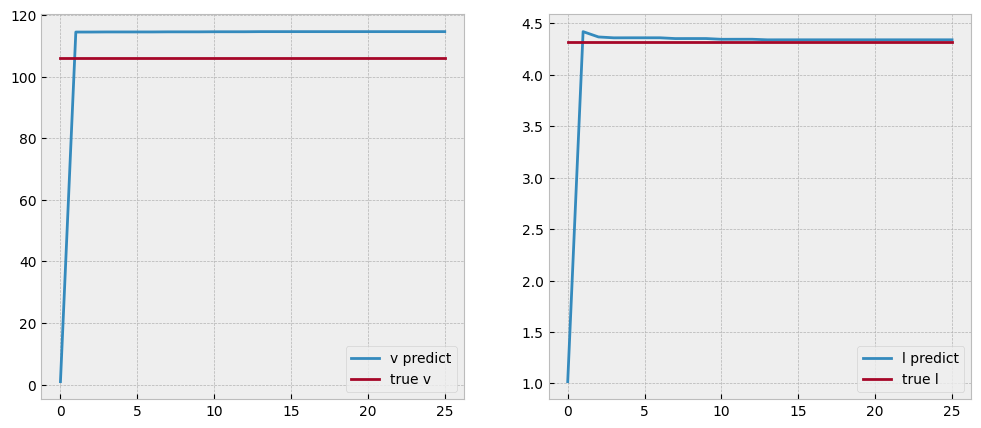

In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(Theta_predict[:, 0], label="v predict")
plt.plot(Theta[0]*np.ones(len(Theta_predict[:, 0])), label="true v")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Theta_predict[:, 1], label="l predict")
plt.plot(Theta[1]*np.ones(len(Theta_predict[:, 0])), label="true l")
plt.legend()
plt.show()